In [ ]:
"""
Improved CQR Age Estimation Model - Fixed Version
Key Changes:
1. Equal loss weights (no boundary emphasis)
2. Consistent 224x224 resolution
3. Monotonicity constraint
4. Discriminative learning rates
5. More training epochs
6. Learning rate scheduler
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. Configuration
# ==========================================
BATCH_SIZE = 64
# LEARNING_RATE = 1e-4
HEAD_LR = 5e-4  # Higher LR for head
BACKBONE_LR = 1e-4  # Lower LR for backbone
EPOCHS = 50  # Increased from 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
QUANTILES = [0.025, 0.5, 0.975]
PATIENCE = 7  # Increased from 3
MIN_DELTA = 0.005  # Smaller threshold
model_path = "swin_quantile_final.pth"

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# ==========================================
# 2. Data Preparation - FIXED RESOLUTION
# ==========================================
print("Loading dataset...")
hf_dataset = load_dataset("vtsouval/utkface-cropped", split="train")

# FIXED: All transforms now use 224x224 (not 256x256)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.Resize((224, 224)),  # FIXED: was 256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # FIXED: was 256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class UTKFaceDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        age = item['age']
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age, dtype=torch.float32)

# Create splits
split_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)
val_ds_raw = split_dataset['test']
split_dataset = split_dataset['train'].train_test_split(test_size=0.25, seed=42)
train_ds_raw = split_dataset['train']
test_ds_raw = split_dataset['test']

train_dataset = UTKFaceDataset(train_ds_raw, transform=train_transform)
train_dataset_v2 = UTKFaceDataset(train_ds_raw, transform=val_transform)
val_dataset = UTKFaceDataset(val_ds_raw, transform=val_transform)
test_dataset = UTKFaceDataset(test_ds_raw, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
train_loader_v2 = DataLoader(train_dataset_v2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

Loading dataset...


data/train-00000-of-00001.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23704 [00:00<?, ? examples/s]

Train samples: 14222
Val samples:   4741
Test samples:  4741


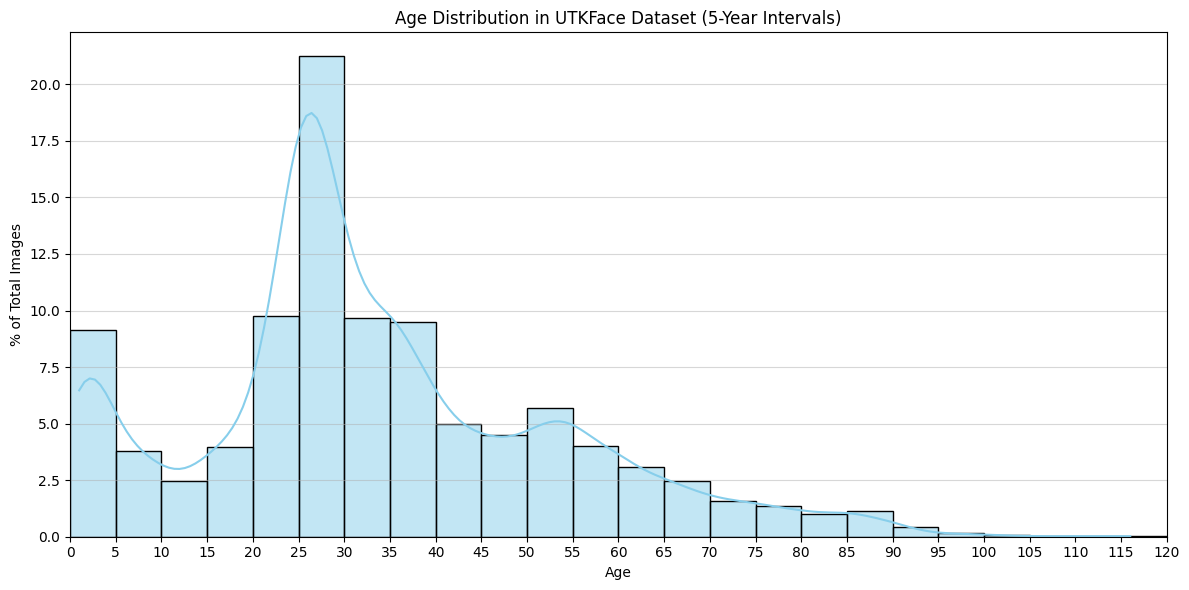

count    23704.000000
mean        33.299992
std         19.885628
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


In [ ]:
df = hf_dataset.select_columns(['age']).to_pandas()


# Define bin edges explicitly (0, 5, 10, ..., 120)
bin_edges = np.arange(0, 121, 5)

plt.figure(figsize=(12, 6))
sns.histplot(df['age'], bins=bin_edges, kde=True, color='skyblue', stat='percent')

plt.title('Age Distribution in UTKFace Dataset (5-Year Intervals)')
plt.xlabel('Age')
plt.ylabel('% of Total Images')
plt.grid(axis='y', alpha=0.5)

# Set x-ticks to match the bin edges for clarity
plt.xticks(bin_edges)
plt.xlim(0, 120)

plt.tight_layout()
plt.show()

# Print Summary Statistics
print(df['age'].describe())

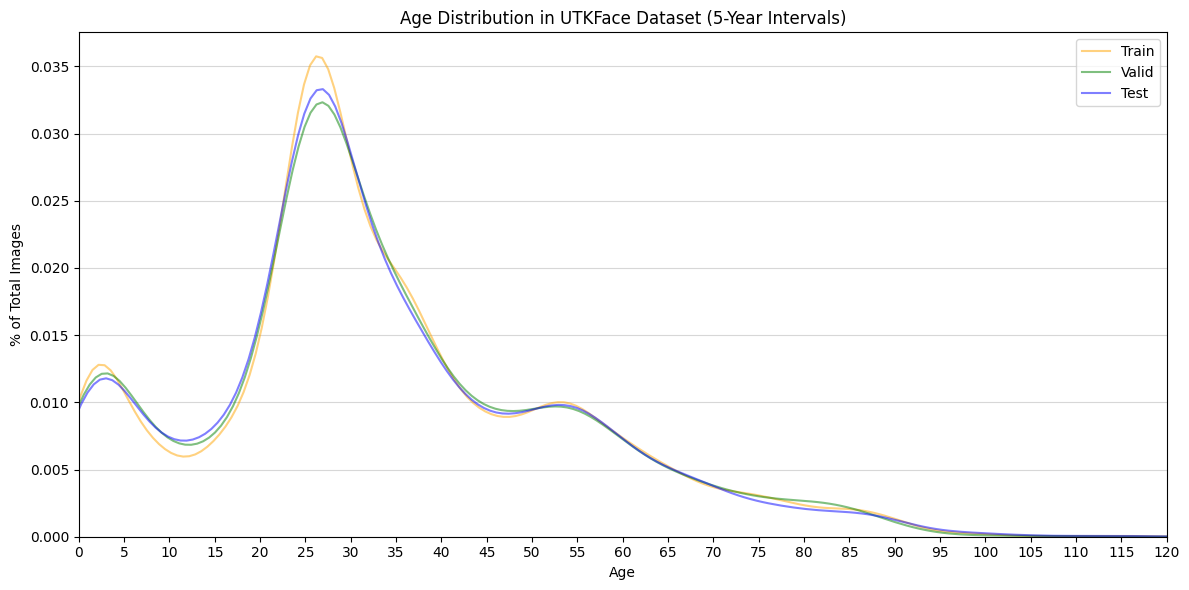

count    23704.000000
mean        33.299992
std         19.885628
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


In [ ]:
df_train = train_ds_raw.select_columns(['age']).to_pandas()
df_val = val_ds_raw.select_columns(['age']).to_pandas()
df_est = test_ds_raw.select_columns(['age']).to_pandas()


# Define bin edges explicitly (0, 5, 10, ..., 120)
bin_edges = np.arange(0, 121, 5)

plt.figure(figsize=(12, 6))
# sns.histplot(df['age'], bins=bin_edges, kde=True, color='skyblue', stat='percent', legend='Train',)
# sns.histplot(df_train['age'], bins=bin_edges, kde=True, color='orange', stat='percent', legend='Valid')
# sns.histplot(df_val['age'], bins=bin_edges, kde=True, color='green', stat='percent', legend='Test')
sns.kdeplot(df_train['age'], fill=False, color='orange', alpha=0.5, label='Train')
sns.kdeplot(df_val['age'], fill=False, color='green', alpha=0.5, label='Valid')
sns.kdeplot(df_est['age'], fill=False, color='blue', alpha=0.5, label='Test')


plt.title('Age Distribution in UTKFace Dataset (5-Year Intervals)')
plt.xlabel('Age')
plt.ylabel('% of Total Images')
plt.grid(axis='y', alpha=0.5)

# Set x-ticks to match the bin edges for clarity
plt.xticks(bin_edges)
plt.xlim(0, 120)
plt.legend()

plt.tight_layout()
plt.show()

# Print Summary Statistics
print(df['age'].describe())

In [ ]:
# ==========================================
# 3. IMPROVED Loss Function
# ==========================================
class ImprovedMultiQuantileLoss(nn.Module):
    """
    Key improvements:
    1. Equal weights (no boundary emphasis)
    2. Enforces monotonicity
    3. Optional width penalty
    """
    def __init__(self, quantiles, width_penalty=0.0):
        super().__init__()
        self.quantiles = quantiles
        self.width_penalty = width_penalty

    def forward(self, preds, target):
        assert preds.shape[1] == len(self.quantiles)

        # CRITICAL: Enforce monotonicity (q1 <= q2 <= q3)
        preds = torch.sort(preds, dim=1).values

        loss = 0
        if target.dim() == 1:
            target = target.view(-1, 1)

        # FIXED: Equal weights for all quantiles
        for i, q in enumerate(self.quantiles):
            q_pred = preds[:, i:i+1]
            error = target - q_pred
            q_loss = torch.max(q * error, (q - 1) * error)
            loss += q_loss.mean()  # No weighting!

        # Optional: Penalize wide intervals
        if self.width_penalty > 0:
            interval_width = preds[:, -1] - preds[:, 0]
            width_loss = self.width_penalty * interval_width.mean()
            loss += width_loss

        return loss

# ==========================================
# 4. IMPROVED Model Architecture
# ==========================================
def build_improved_quantile_swin():
    """
    Improvements:
    1. Deeper head network
    2. Proper freezing strategy
    3. Enforces quantile ordering
    """
    weights = Swin_V2_T_Weights.DEFAULT
    model = swin_v2_t(weights=weights)

    # Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    # Replace with improved head
    n_inputs = model.head.in_features
    model.head = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, len(QUANTILES))
    )

    # # Unfreeze Stage 4 and head
    # print("Unfreezing Stage 4, Final Norm, and Head...")
    # for name, param in model.named_parameters():
    #     if any(x in name for x in ["features.7", "norm", "head"]):
    #         param.requires_grad = True

    for name, param in model.named_parameters():
        # "features.5" = Stage 3 (Deep, Heavy)
        # "features.7" = Stage 4 (Final)
        # "norm"       = Final Norm
        if any(x in name for x in ["features.5", "features.6", "features.7", "norm"]):
            param.requires_grad = True

    return model

# Initialize
model = build_improved_quantile_swin().to(DEVICE)
criterion = ImprovedMultiQuantileLoss(QUANTILES, width_penalty=0.05).to(DEVICE)

# IMPROVED: Discriminative learning rates
head_params = list(model.head.parameters())
backbone_params = [p for n, p in model.named_parameters()
                   if p.requires_grad and 'head' not in n]

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': BACKBONE_LR, 'weight_decay': 0.01},
    {'params': head_params, 'lr': HEAD_LR, 'weight_decay': 0.01}
])

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                              patience=3, min_lr=1e-7)

# # Configuration
# T_0 = 10  # First cycle length
# T_mult = 2  # Each cycle is 2x longer (10, 20, 20, ...)
# eta_min = 1e-7  # Minimum learning rate

# # Create scheduler
# scheduler = CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=T_0,      # First restart after 10 epochs
#     T_mult=T_mult, # Next restart after 20, then 40 epochs
#     eta_min=eta_min
# )

print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Total parameters:           {sum(p.numel() for p in model.parameters()):,}")

Total trainable parameters: 26,312,699
Total parameters:           27,812,717


In [ ]:
# ==========================================
# 5. Training Functions
# ==========================================
def train_one_epoch(epoch_index):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                       desc=f"Epoch {epoch_index}/{EPOCHS}")

    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        current_avg_loss = running_loss / (i + 1)
        progress_bar.set_postfix({'loss': f'{current_avg_loss:.4f}'})

    return running_loss / len(train_loader)


def validate(data_loader, desc="Validation"):
    model.eval()
    running_loss = 0.0
    total = 0
    covered = 0
    total_width = 0.0
    total_abs_error = 0.0
    median_idx = QUANTILES.index(0.5)

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            outputs_sorted = torch.sort(outputs, dim=1).values
            q_low = outputs_sorted[:, 0]
            q_high = outputs_sorted[:, -1]

            covered += ((labels >= q_low) & (labels <= q_high)).sum().item()
            total_width += (q_high - q_low).sum().item()
            median_pred = outputs_sorted[:, median_idx]
            total_abs_error += torch.abs(labels - median_pred).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(data_loader)
    coverage = covered / total
    avg_width = total_width / total
    mae_median = total_abs_error / total

    return avg_loss, coverage, avg_width, mae_median

In [ ]:
# ==========================================
# 6. Training Loop
# ==========================================

print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Batch size:       {BATCH_SIZE}")
print(f"Head LR:          {HEAD_LR}")
print(f"Backbone LR:      {BACKBONE_LR}")
print(f"Epochs:           {EPOCHS}")
print(f"Patience:         {PATIENCE}")
# print(f"Scheduler:        CosineAnnealingWarmRestarts (T_0=10, T_mult=2)")
print(f"Scheduler:        ReduceLROnPlateau")
print(f"Width Penalty:    0.01")
print(f"Image Resolution: 224x224")
print(f"Loss Weights:     Equal (Fixed)")
print("="*60 + "\n")

best_val_loss = float('inf')
best_val_width = float('inf')
epochs_no_improve = 0

print("Starting training...\n")

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(epoch)
    val_loss, val_cr, val_iw, val_mae = validate(val_loader, desc=f"Epoch {epoch} Val")
    train_loss_eval, train_cr, train_iw, train_mae = validate(train_loader_v2,
                                                               desc=f"Epoch {epoch} Train")

    # Step scheduler
    scheduler.step(val_loss)
    current_lr = scheduler.get_last_lr()[0]

    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{EPOCHS} Summary")
    print(f"{'='*60}")
    print(f"LR: {current_lr:.2e}")
    print(f"Train Loss: {train_loss_eval:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train MAE:  {train_mae:.2f}     | Val MAE:  {val_mae:.2f}")
    print(f"Train Cov:  {train_cr*100:.2f}%    | Val Cov:  {val_cr*100:.2f}%")
    print(f"Train Width: {train_iw:.2f}      | Val Width: {val_iw:.2f}")

    # Save best model
    if val_loss < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss
        best_val_width = val_iw
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'val_width': val_iw,
            'val_coverage': val_cr
        }, model_path)
        print(f"✓ SAVED new best model (Val Loss={best_val_loss:.4f}, Width={val_iw:.2f})")
    else:
        epochs_no_improve += 1
        print(f"! No improvement for {epochs_no_improve}/{PATIENCE} epochs")

    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(f"\n🛑 Early stopping! No improvement for {PATIENCE} epochs.")
        break

    print("="*60)

print("\n✅ Training completed!")


TRAINING CONFIGURATION
Batch size:       64
Head LR:          0.0005
Backbone LR:      0.0001
Epochs:           20
Patience:         3
Scheduler:        ReduceLROnPlateau
Width Penalty:    0.01
Image Resolution: 224x224
Loss Weights:     Equal (Fixed)

Starting training...



Epoch 1/20: 100%|██████████| 223/223 [03:16<00:00,  1.14it/s, loss=9.5502]



Epoch 1/20 Summary
LR: 1.00e-04
Train Loss: 5.7059 | Val Loss: 5.5278
Train MAE:  7.71     | Val MAE:  7.50
Train Cov:  91.35%    | Val Cov:  91.86%
Train Width: 40.73      | Val Width: 40.22
✓ SAVED new best model (Val Loss=5.5278, Width=40.22)


Epoch 2/20: 100%|██████████| 223/223 [03:16<00:00,  1.13it/s, loss=5.4206]



Epoch 2/20 Summary
LR: 1.00e-04
Train Loss: 4.4053 | Val Loss: 4.4179
Train MAE:  6.05     | Val MAE:  6.03
Train Cov:  95.91%    | Val Cov:  95.57%
Train Width: 33.36      | Val Width: 32.96
✓ SAVED new best model (Val Loss=4.4179, Width=32.96)


Epoch 3/20: 100%|██████████| 223/223 [03:16<00:00,  1.14it/s, loss=4.9381]



Epoch 3/20 Summary
LR: 1.00e-04
Train Loss: 3.9116 | Val Loss: 4.0235
Train MAE:  5.37     | Val MAE:  5.49
Train Cov:  94.68%    | Val Cov:  94.09%
Train Width: 28.33      | Val Width: 27.97
✓ SAVED new best model (Val Loss=4.0235, Width=27.97)


Epoch 4/20: 100%|██████████| 223/223 [03:15<00:00,  1.14it/s, loss=4.6571]



Epoch 4/20 Summary
LR: 1.00e-04
Train Loss: 3.6987 | Val Loss: 3.8115
Train MAE:  5.11     | Val MAE:  5.26
Train Cov:  95.07%    | Val Cov:  94.26%
Train Width: 28.20      | Val Width: 27.86
✓ SAVED new best model (Val Loss=3.8115, Width=27.86)


Epoch 5/20: 100%|██████████| 223/223 [03:16<00:00,  1.14it/s, loss=4.4640]



Epoch 5/20 Summary
LR: 1.00e-04
Train Loss: 3.5207 | Val Loss: 3.7217
Train MAE:  4.89     | Val MAE:  5.14
Train Cov:  95.63%    | Val Cov:  94.03%
Train Width: 26.75      | Val Width: 26.41
✓ SAVED new best model (Val Loss=3.7217, Width=26.41)


Epoch 6/20: 100%|██████████| 223/223 [03:16<00:00,  1.14it/s, loss=4.3249]



Epoch 6/20 Summary
LR: 1.00e-04
Train Loss: 3.4340 | Val Loss: 3.6489
Train MAE:  4.75     | Val MAE:  5.03
Train Cov:  95.75%    | Val Cov:  93.97%
Train Width: 26.18      | Val Width: 25.85
✓ SAVED new best model (Val Loss=3.6489, Width=25.85)


Epoch 7/20: 100%|██████████| 223/223 [03:16<00:00,  1.14it/s, loss=4.1688]
                                                                


Epoch 7/20 Summary
LR: 1.00e-04
Train Loss: 3.5298 | Val Loss: 3.8709
Train MAE:  4.98     | Val MAE:  5.30
Train Cov:  92.51%    | Val Cov:  90.47%
Train Width: 21.80      | Val Width: 21.50
! No improvement for 1/3 epochs


Epoch 8/20: 100%|██████████| 223/223 [03:15<00:00,  1.14it/s, loss=4.0320]
                                                                


Epoch 8/20 Summary
LR: 1.00e-04
Train Loss: 4.1393 | Val Loss: 4.3468
Train MAE:  5.79     | Val MAE:  6.05
Train Cov:  91.04%    | Val Cov:  89.47%
Train Width: 28.11      | Val Width: 27.82
! No improvement for 2/3 epochs


Epoch 9/20: 100%|██████████| 223/223 [03:16<00:00,  1.14it/s, loss=4.0094]
                                                                


Epoch 9/20 Summary
LR: 1.00e-04
Train Loss: 3.3170 | Val Loss: 3.6753
Train MAE:  4.59     | Val MAE:  5.04
Train Cov:  96.04%    | Val Cov:  93.93%
Train Width: 25.92      | Val Width: 25.59
! No improvement for 3/3 epochs

🛑 Early stopping! No improvement for 3 epochs.

✅ Training completed!


In [ ]:
# model.load_state_dict(torch.load(model_path)['model_state_dict'])
# Load best model
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# def predict_on_dataset(model, loader, device):
#     model.eval()
#     all_preds = []
#     all_targets = []

#     print("Generating predictions...")
#     with torch.no_grad():
#         for inputs, targets in tqdm(loader):
#             inputs = inputs.to(device)

#             # Forward pass
#             outputs = model(inputs)

#             # Save results
#             all_preds.append(outputs.cpu())
#             all_targets.append(targets.cpu())

#     # Concatenate all batches into one big tensor
#     all_preds = torch.cat(all_preds, dim=0)   # Shape: [N, 3]
#     all_targets = torch.cat(all_targets, dim=0) # Shape: [N]

#     return all_preds, all_targets

# # model.load_state_dict(torch.load("swin_quantile_best.pth"))
# preds_train_swin, targets_train_swin = predict_on_dataset(model, train_loader_v2, DEVICE)
# preds_val_swin, targets_val_swin = predict_on_dataset(model, val_loader, DEVICE)
# preds_test_swin, targets_test_swin = predict_on_dataset(model, test_loader, DEVICE)

In [ ]:
def predict_on_dataset(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    print("Generating predictions...")
    with torch.no_grad():
        for inputs, targets in tqdm(loader):
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # --- CRITICAL FIX: SORT OUTPUTS ---
            # Just like in your validation loop and loss function
            outputs = torch.sort(outputs, dim=1).values
            # ----------------------------------

            # Save results
            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())

    # Concatenate all batches into one big tensor
    all_preds = torch.cat(all_preds, dim=0)   # Shape: [N, 3]
    all_targets = torch.cat(all_targets, dim=0) # Shape: [N]

    return all_preds, all_targets

preds_train_swin, targets_train_swin = predict_on_dataset(model, train_loader_v2, DEVICE)
preds_val_swin, targets_val_swin = predict_on_dataset(model, val_loader, DEVICE)
preds_test_swin, targets_test_swin = predict_on_dataset(model, test_loader, DEVICE)

Generating predictions...


100%|██████████| 223/223 [01:13<00:00,  3.04it/s]


Generating predictions...


100%|██████████| 75/75 [00:25<00:00,  2.98it/s]


Generating predictions...


100%|██████████| 75/75 [00:27<00:00,  2.74it/s]


In [ ]:
preds_train_swin[:, 0] = torch.clamp(preds_train_swin[:, 0], min=0.0)
preds_val_swin[:, 0] = torch.clamp(preds_val_swin[:, 0], min=0.0)
preds_test_swin[:, 0] = torch.clamp(preds_test_swin[:, 0], min=0.0)

In [ ]:
# calculate R2 with median value
from sklearn.metrics import r2_score
print("Swin R2")
print("Train R2", round(r2_score(targets_train_swin, preds_train_swin[:, 1]),2))
print("Val R2", round(r2_score(targets_val_swin, preds_val_swin[:, 1]),2))
print("Test R2", round(r2_score(targets_test_swin, preds_test_swin[:, 1]),2))

Swin R2
Train R2 0.93
Val R2 0.88
Test R2 0.88


In [ ]:
# prin MAE
from sklearn.metrics import mean_absolute_error
print("Swim MAE")
print("Train MAE", round(mean_absolute_error(targets_train_swin, preds_train_swin[:, 1]),2))
print("Val MAE", round(mean_absolute_error(targets_val_swin, preds_val_swin[:, 1]),2))
print("Test MAE", round(mean_absolute_error(targets_test_swin, preds_test_swin[:, 1]),2))

Swim MAE
Train MAE 3.69
Val MAE 4.67
Test MAE 4.75


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch

# Define the folder path
folder_path = '/content/drive/MyDrive/resnet_pt'

# Check if the folder exists and list files
if os.path.exists(folder_path):
    print("Folder found! Here are the files:")
    print(os.listdir(folder_path))
else:
    print(f"Folder not found at: {folder_path}")

Folder found! Here are the files:
['resnet_pt']


In [ ]:
preds_train_resnet = torch.load('/content/drive/MyDrive/resnet_pt/resnet_pt/preds_train_resnet.pt')
targets_train_resnet = torch.load('/content/drive/MyDrive/resnet_pt/resnet_pt/targets_train_resnet.pt')

prest_val_resnet = torch.load('/content/drive/MyDrive/resnet_pt/resnet_pt/preds_val_resnet.pt')
targets_val_resnet = torch.load('/content/drive/MyDrive/resnet_pt/resnet_pt/targets_val_resnet.pt')

prest_test_resnet = torch.load('/content/drive/MyDrive/resnet_pt/resnet_pt/preds_test_resnet.pt')
targets_test_resnet = torch.load('/content/drive/MyDrive/resnet_pt/resnet_pt/targets_test_resnet.pt')

In [ ]:
preds_train_resnet[:, 0] = torch.clamp(preds_train_resnet[:, 0], min=0.0)
prest_val_resnet[:, 0] = torch.clamp(prest_val_resnet[:, 0], min=0.0)
prest_test_resnet[:, 0] = torch.clamp(prest_test_resnet[:, 0], min=0.0)

In [ ]:
from sklearn.metrics import r2_score
print("ResNet R2")
print("Train R2", round(r2_score(targets_train_resnet, preds_train_resnet[:, 1]),2))
print("Val R2", round(r2_score(targets_val_resnet, prest_val_resnet[:, 1]),2))
print("Test R2", round(r2_score(targets_test_resnet, prest_test_resnet[:, 1]),2))

ResNet R2
Train R2 0.92
Val R2 0.86
Test R2 0.86


In [ ]:
from sklearn.metrics import mean_absolute_error
print("ResNet MAE")
print("Train MAE", round(mean_absolute_error(targets_train_resnet, preds_train_resnet[:, 1]),2))
print("Val MAE", round(mean_absolute_error(targets_val_resnet, prest_val_resnet[:, 1]),2))
print("Test MAE", round(mean_absolute_error(targets_test_resnet, prest_test_resnet[:, 1]),2))

ResNet MAE
Train MAE 4.15
Val MAE 5.13
Test MAE 5.19


In [ ]:
def evaluate_cqr(preds, targets):
    # preds column 0 = Lower Bound (q=0.025)
    # preds column 2 = Upper Bound (q=0.975)

    lower_bound = preds[:, 0]
    upper_bound = preds[:, 2]

    # 1. Coverage: Is target inside [Lower, Upper]?
    in_interval = (targets >= lower_bound) & (targets <= upper_bound)
    coverage = in_interval.float().mean().item()

    # 2. Width: How wide is the interval?
    widths = upper_bound - lower_bound
    avg_width = widths.mean().item()

    print(f"--- CQR Evaluation ---")
    print(f"Coverage Rate: {coverage * 100:.2f}% (Target: 95.0%)")
    print(f"Avg Interval Width: {avg_width:.2f} years")

    return coverage, avg_width

# Example Usage:
print("Swin")
print("Train")
_ = evaluate_cqr(preds_train_swin, targets_train_swin)
print("\n Validation")
_ = evaluate_cqr(preds_val_swin, targets_val_swin)
print("\n Test")
_ = evaluate_cqr(preds_test_swin, targets_test_swin)

Swin
Train
--- CQR Evaluation ---
Coverage Rate: 92.35% (Target: 95.0%)
Avg Interval Width: 17.96 years

 Validation
--- CQR Evaluation ---
Coverage Rate: 85.93% (Target: 95.0%)
Avg Interval Width: 17.81 years

 Test
--- CQR Evaluation ---
Coverage Rate: 85.59% (Target: 95.0%)
Avg Interval Width: 17.83 years


In [ ]:
print("ResNet")
print("Train")
_ = evaluate_cqr(preds_train_resnet, targets_train_resnet)
print("\n Validation")
_ = evaluate_cqr(prest_val_resnet, targets_val_resnet)
print("\n Test")
_ = evaluate_cqr(prest_test_resnet, targets_test_resnet)

ResNet
Train
--- CQR Evaluation ---
Coverage Rate: 96.82% (Target: 95.0%)
Avg Interval Width: 25.31 years

 Validation
--- CQR Evaluation ---
Coverage Rate: 93.12% (Target: 95.0%)
Avg Interval Width: 25.03 years

 Test
--- CQR Evaluation ---
Coverage Rate: 93.63% (Target: 95.0%)
Avg Interval Width: 25.13 years


In [ ]:
# ==========================================
# 5. Run Calibration (Using Existing Preds)
# ==========================================
import numpy as np
import torch

ALPHA = 0.05  # 95% coverage target

def calculate_conformal_correction(preds, targets, alpha=0.05):
    """
    Calculates the Conformal Prediction correction factor Q
    using pre-calculated predictions and targets.
    """
    print("Calculating Conformity Scores (Calibration)...")

    # Ensure inputs are on CPU for numpy operations
    if isinstance(preds, torch.Tensor):
        preds = preds.cpu()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu()

    # 1. Extract Quantiles
    # Assuming preds shape is [N, 3] -> (q_low, q_median, q_high)
    # We use index 0 for Low and index -1 (or 2) for High
    q_low = preds[:, 0]
    q_high = preds[:, -1]

    # 2. Calculate Conformity Scores
    # E_i = max(q_low - y, y - q_high)
    error_low = q_low - targets
    error_high = targets - q_high

    # Element-wise max
    scores = torch.max(error_low, error_high).numpy()

    # 3. Calculate Q (The Correction Factor)
    # We want the (1 - alpha)th quantile of the scores
    n = len(scores)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_level = min(1.0, q_level) # Clip to 1.0

    Q = np.quantile(scores, q_level, method='higher')

    return Q

# ---------------------------------------------------------
# EXECUTION
# ---------------------------------------------------------

# Step A: Calculate Q using the VALIDATION set predictions
# (Use the sorted predictions from your fixed predict_on_dataset function)
Q_correction_swin = calculate_conformal_correction(preds_val_swin, targets_val_swin, ALPHA)

print(f"\n======== CALIBRATION RESULTS Swin ========")
print(f"Alpha target:        {ALPHA} (95% Coverage)")
print(f"Correction Factor Q: {Q_correction_swin:.4f}")

if Q_correction_swin < 0:
    print(">> Q is NEGATIVE. The raw model was too conservative (intervals too wide).")
    print(">> CQR will SHRINK the intervals.")
else:
    print(">> Q is POSITIVE. The raw model was overconfident (intervals too narrow).")
    print(">> CQR will EXPAND the intervals.")

Calculating Conformity Scores (Calibration)...

======== CALIBRATION RESULTS Swin ========
Alpha target:        0.05 (95% Coverage)
Correction Factor Q: 3.4956
>> Q is POSITIVE. The raw model was overconfident (intervals too narrow).
>> CQR will EXPAND the intervals.


In [ ]:
Q_correction_resnet = calculate_conformal_correction(prest_val_resnet, targets_val_resnet, ALPHA)

print(f"\n======== CALIBRATION RESULTS ResNet ========")
print(f"Alpha target:        {ALPHA} (95% Coverage)")
print(f"Correction Factor Q: {Q_correction_resnet:.4f}")

if Q_correction_resnet < 0:
    print(">> Q is NEGATIVE. The raw model was too conservative (intervals too wide).")
    print(">> CQR will SHRINK the intervals.")
else:
    print(">> Q is POSITIVE. The raw model was overconfident (intervals too narrow).")
    print(">> CQR will EXPAND the intervals.")

Calculating Conformity Scores (Calibration)...

======== CALIBRATION RESULTS ResNet ========
Alpha target:        0.05 (95% Coverage)
Correction Factor Q: 1.0130
>> Q is POSITIVE. The raw model was overconfident (intervals too narrow).
>> CQR will EXPAND the intervals.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# 6. Apply CQR to Test Set & Evaluate
# ==========================================
def apply_cqr_and_evaluate(preds, targets, Q_correction, model_name="Model"):
    """
    Applies the Q-correction to test predictions and calculates metrics.
    """
    preds = preds.cpu()
    targets = targets.cpu()

    # 1. Apply Calibration
    # Calibrated Interval = [Low - Q, High + Q]
    # Note: Median (index 1) remains unchanged usually, but we focus on intervals here.
    q_low_calibrated = preds[:, 0] - Q_correction
    q_high_calibrated = preds[:, -1] + Q_correction

    q_low_calibrated[:] = torch.clamp(q_low_calibrated[:], min=0.0)

    # 2. Calculate Coverage
    covered = ((targets >= q_low_calibrated) & (targets <= q_high_calibrated))
    coverage_score = covered.float().mean().item() * 100

    # 3. Calculate Widths
    widths = q_high_calibrated - q_low_calibrated
    avg_width = widths.mean().item()

    # 4. Calculate MAE (Median Absolute Error)
    # We use the raw median (index 1) for point prediction accuracy
    mae = torch.abs(targets - preds[:, 1]).mean().item()

    print(f"--- {model_name} Test Results ---")
    print(f"Coverage:  {coverage_score:.2f}% (Target: {100*(1-ALPHA):.0f}%)")
    print(f"Avg Width: {avg_width:.2f}")
    print(f"MAE:       {mae:.2f}\n")

    return {
        "Model": model_name,
        "Coverage": coverage_score,
        "Avg_Width": avg_width,
        "MAE": mae,
        "Low_Cal": q_low_calibrated,
        "High_Cal": q_high_calibrated,
        "Median": preds[:, 1],
        "Targets": targets,
        "Widths": widths
    }

# Execute Evaluation (Assuming you have preds_test_resnet and targets_test_resnet)
results_swin = apply_cqr_and_evaluate(preds_test_swin, targets_test_swin, Q_correction_swin, "Swin")
results_resnet = apply_cqr_and_evaluate(prest_test_resnet, targets_test_resnet, Q_correction_resnet, "ResNet")

--- Swin Test Results ---
Coverage:  94.73% (Target: 95%)
Avg Width: 24.59
MAE:       4.75

--- ResNet Test Results ---
Coverage:  95.47% (Target: 95%)
Avg Width: 27.10
MAE:       5.19




==================== GENERATING REPORT: Swin Transformer ====================


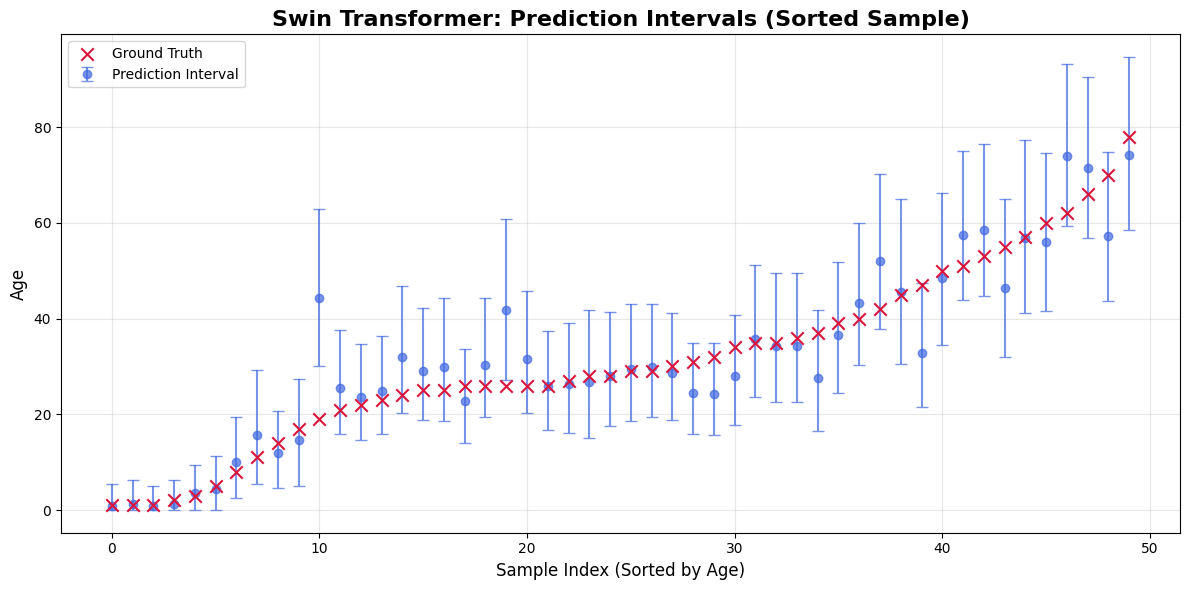

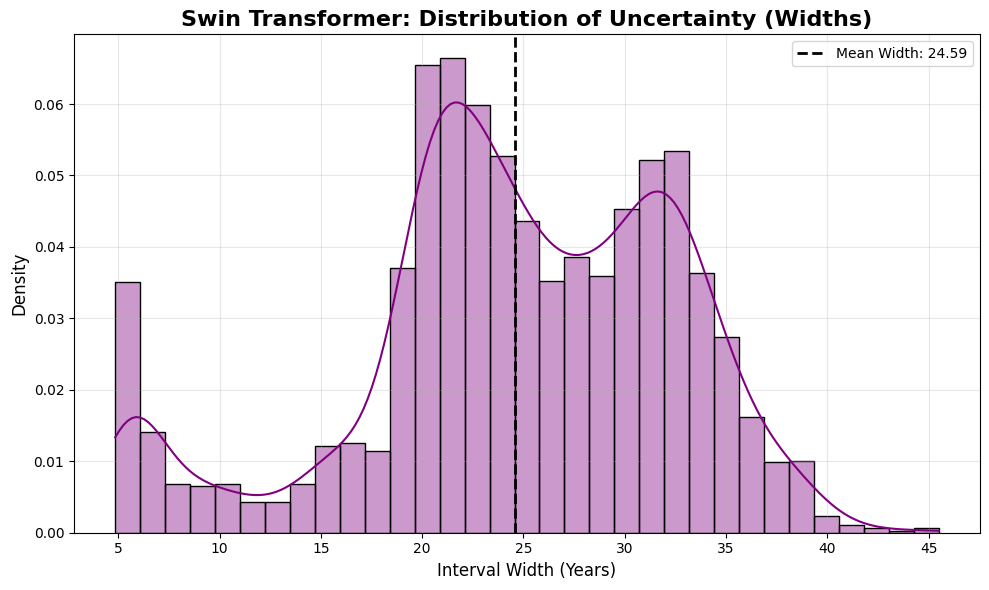

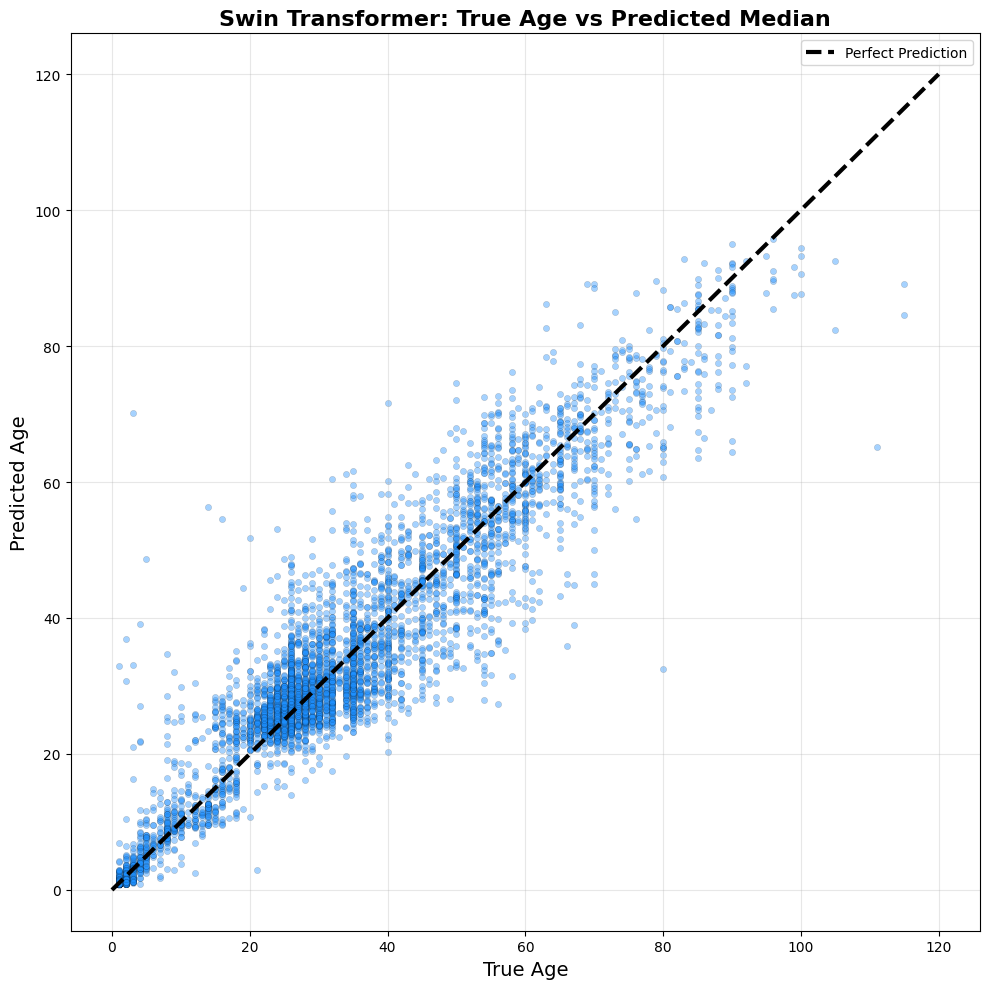

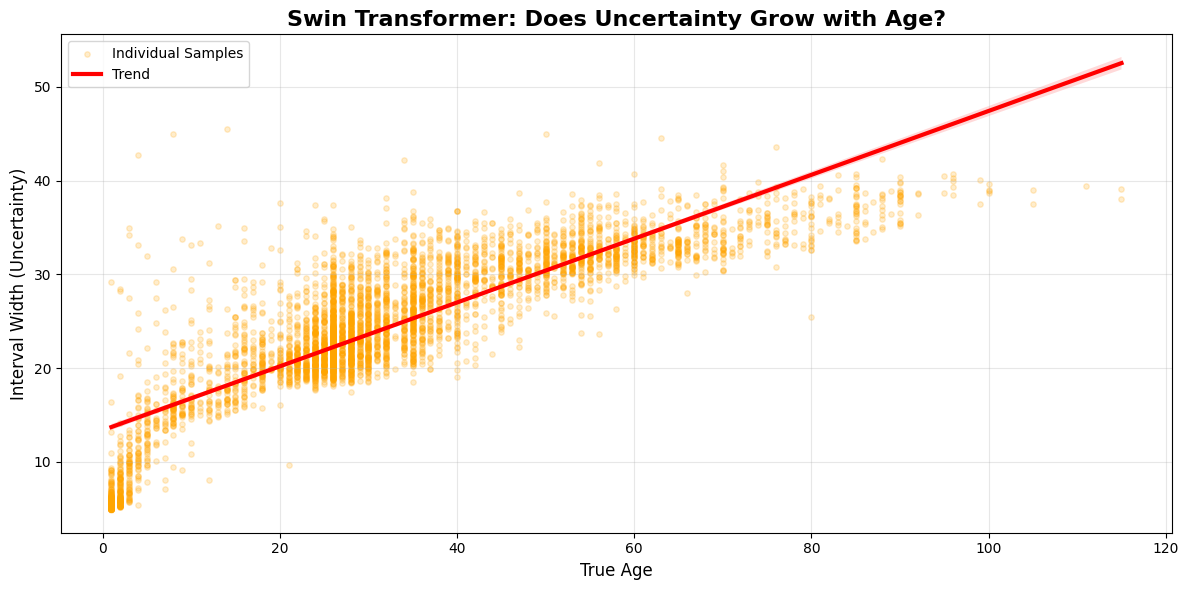

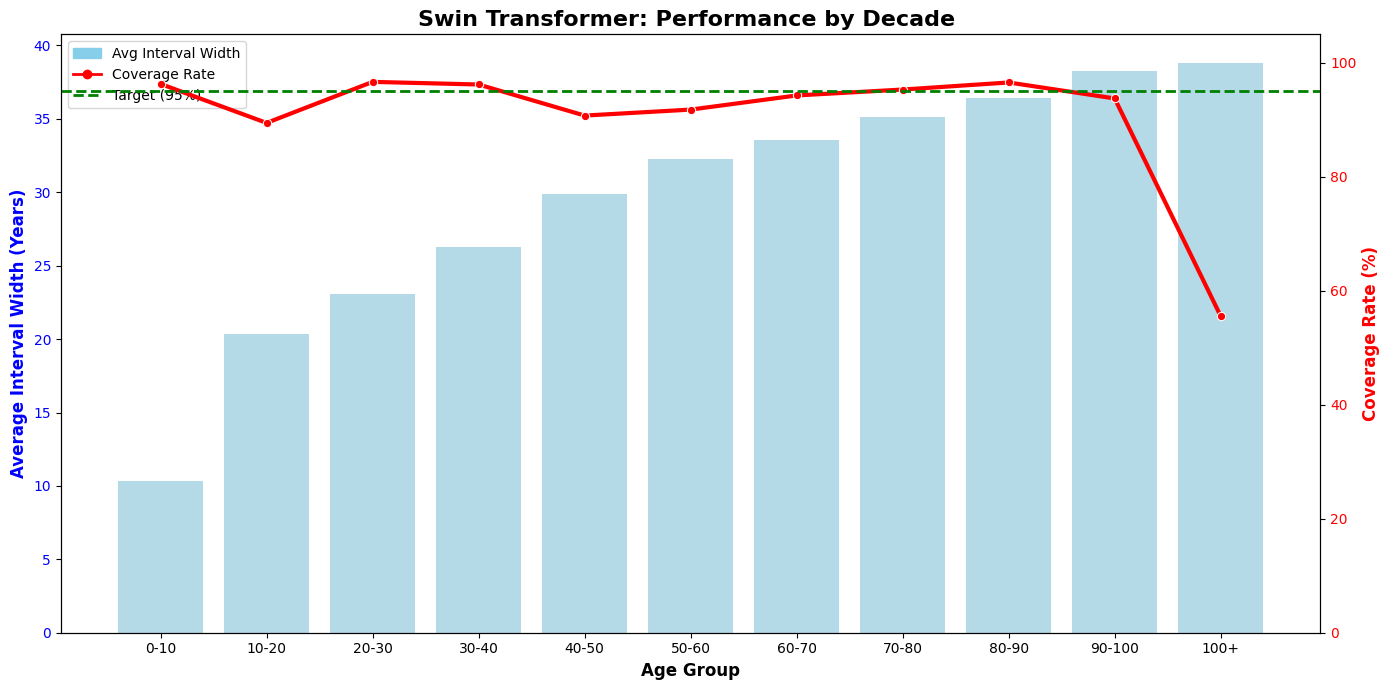



==================== GENERATING REPORT: ResNet ====================


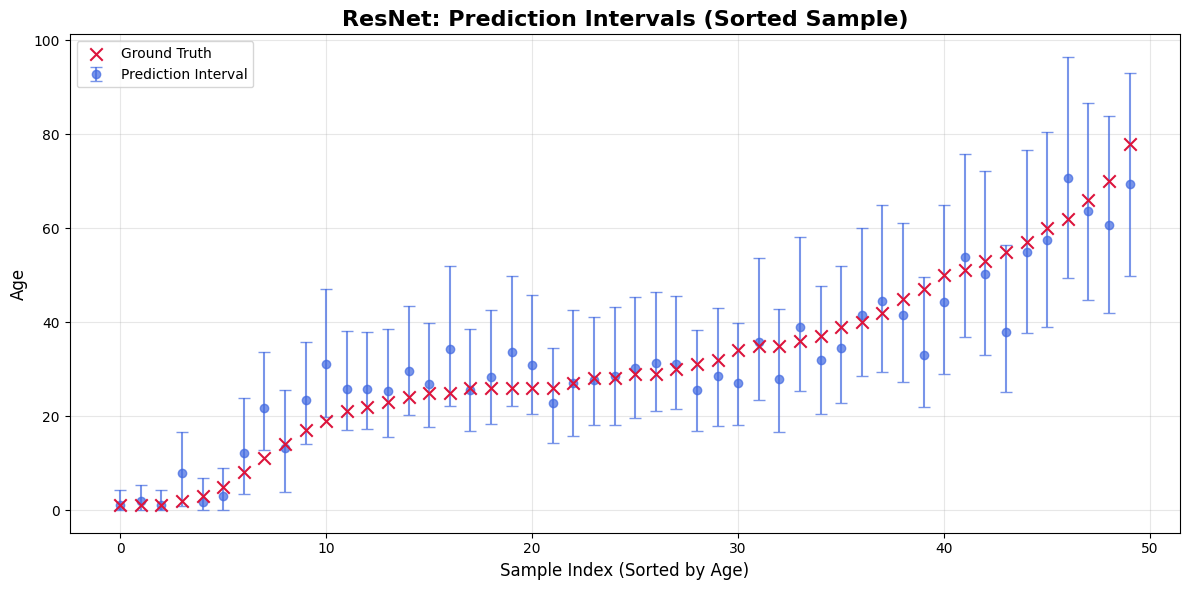

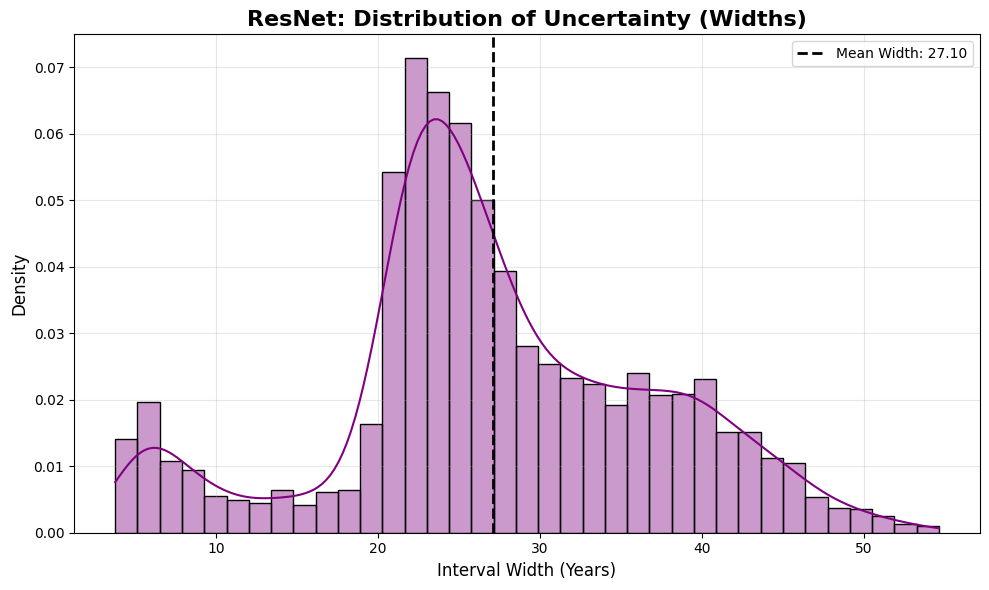

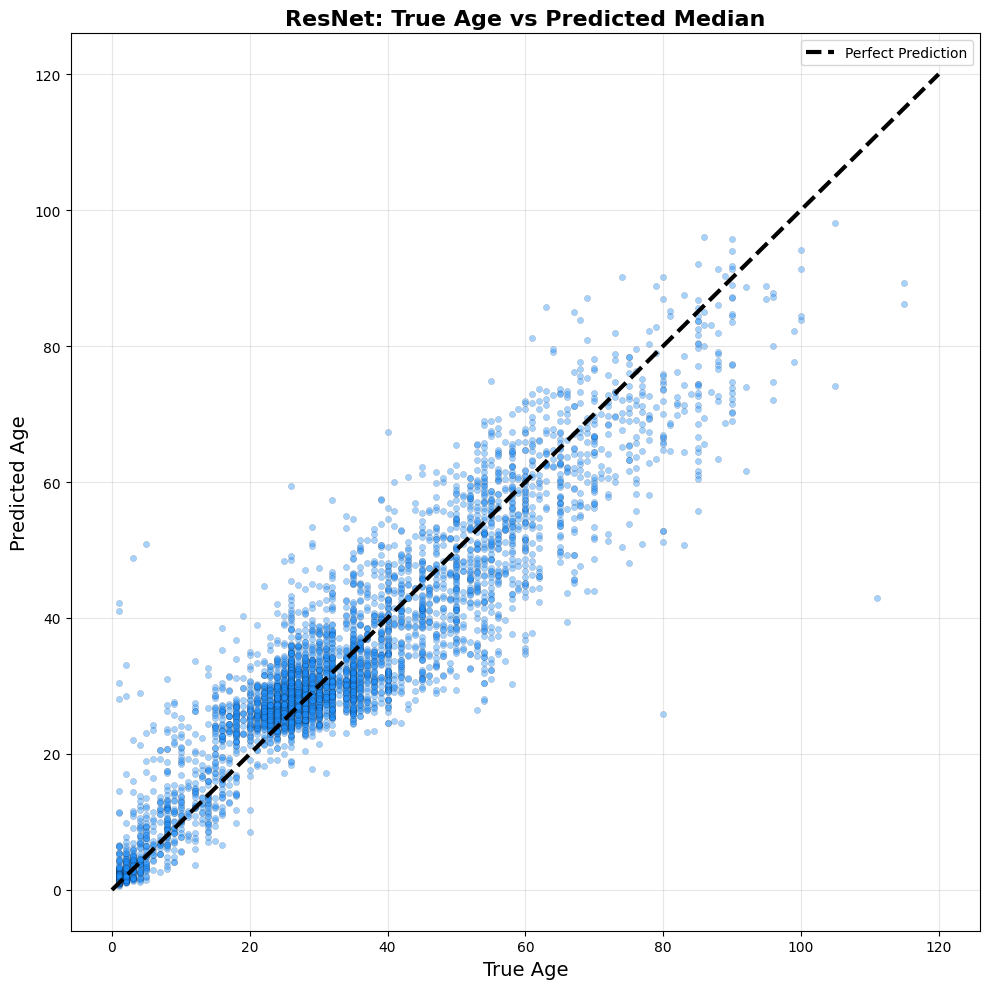

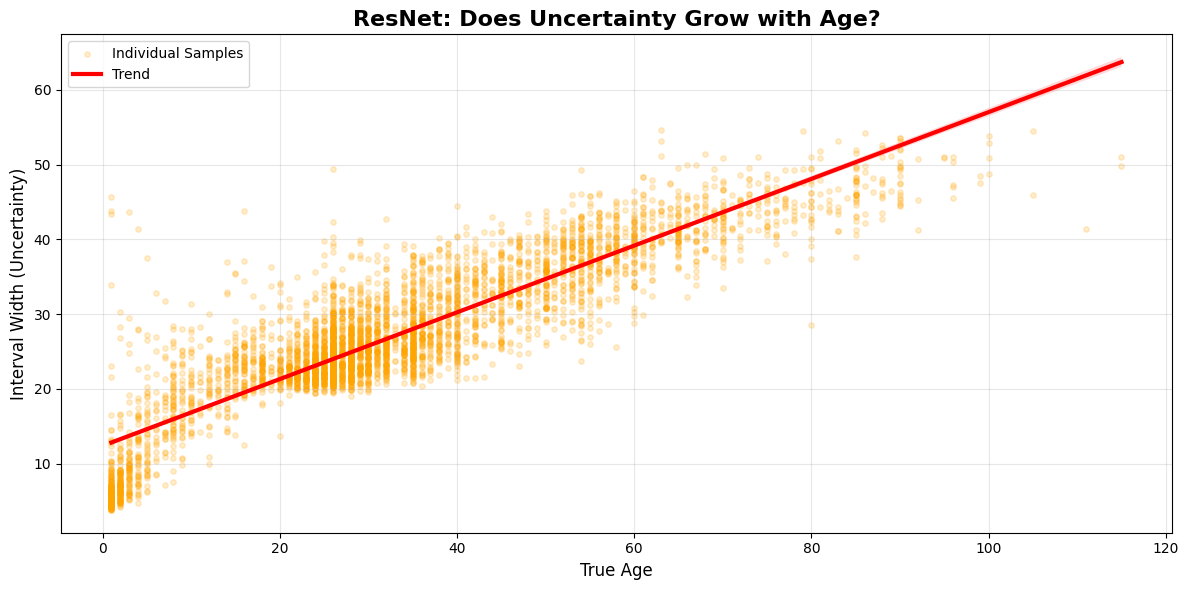

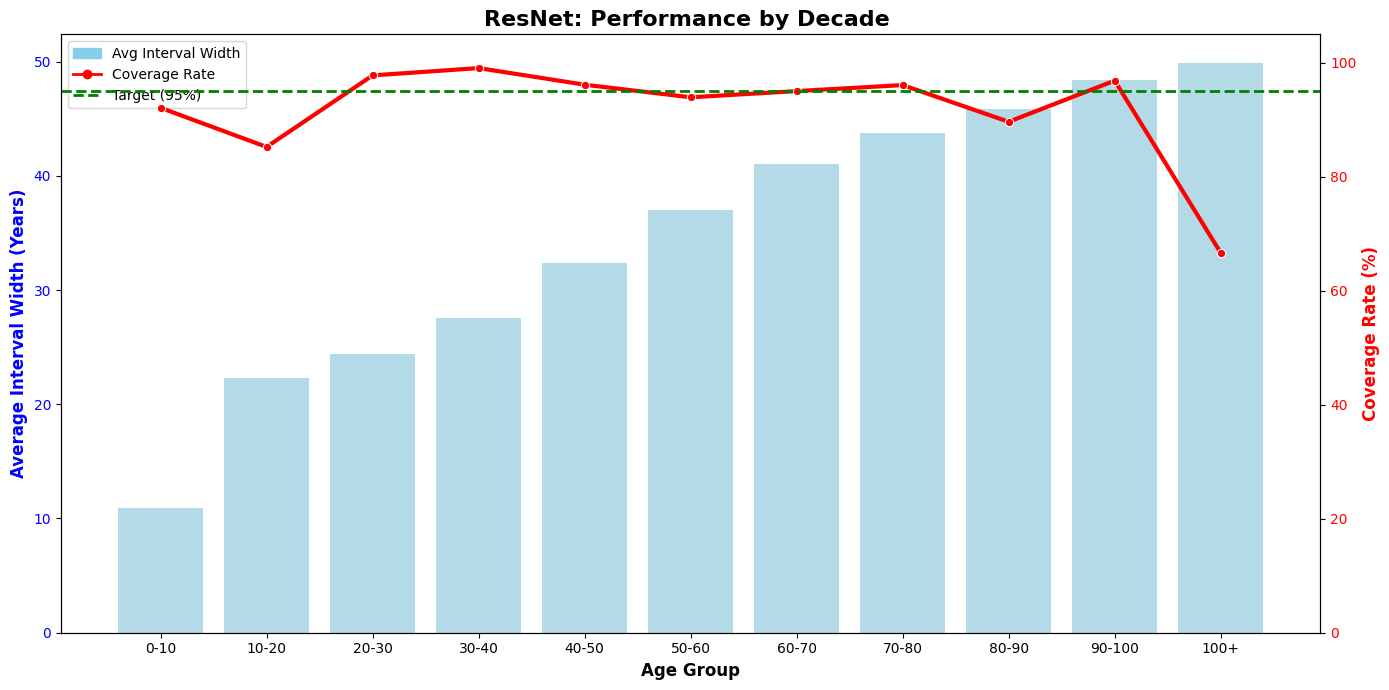

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd

# ==========================================
# 1. Define Plotting Functions
# ==========================================

def plot_1_intervals(results, model_name, n_samples=50):
    """Figure 1: Sorted Prediction Intervals"""
    targets = results["Targets"].numpy()
    median = results["Median"].numpy()
    low = results["Low_Cal"].numpy()
    high = results["High_Cal"].numpy()

    # Sort and slice
    sorted_indices = np.argsort(targets)
    step = len(sorted_indices) // n_samples
    indices = sorted_indices[::step][:n_samples]

    plt.figure(figsize=(12, 6))
    plt.errorbar(
        x=range(n_samples), y=median[indices],
        yerr=[median[indices] - low[indices], high[indices] - median[indices]],
        fmt='o', color='royalblue', alpha=0.7, label='Prediction Interval', capsize=4
    )
    plt.scatter(range(n_samples), targets[indices], color='crimson', marker='x', s=80, label='Ground Truth', zorder=10)

    plt.title(f"{model_name}: Prediction Intervals (Sorted Sample)", fontsize=16, weight='bold')
    plt.xlabel("Sample Index (Sorted by Age)", fontsize=12)
    plt.ylabel("Age", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_2_width_dist(results, model_name):
    """Figure 2: Histogram of Interval Widths"""
    widths = results["Widths"].numpy()
    mean_width = np.mean(widths)

    plt.figure(figsize=(10, 6))
    sns.histplot(widths, kde=True, color='purple', stat='density', alpha=0.4)
    plt.axvline(mean_width, color='k', linestyle='--', linewidth=2, label=f'Mean Width: {mean_width:.2f}')

    plt.title(f"{model_name}: Distribution of Uncertainty (Widths)", fontsize=16, weight='bold')
    plt.xlabel("Interval Width (Years)", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_3_scatter(results, model_name):
    """Figure 3: True vs Predicted Scatter"""
    targets = results["Targets"].numpy()
    median = results["Median"].numpy()

    plt.figure(figsize=(10, 10))
    plt.scatter(targets, median, alpha=0.4, color='dodgerblue', s=20, edgecolor='k', linewidth=0.2)

    # Identity Line
    min_val = 0
    max_val = max(targets.max(), median.max()) + 5
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=3, label='Perfect Prediction')

    plt.title(f"{model_name}: True Age vs Predicted Median", fontsize=16, weight='bold')
    plt.xlabel("True Age", fontsize=14)
    plt.ylabel("Predicted Age", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_4_heteroscedasticity(results, model_name):
    """Figure 4: Age vs Uncertainty (Trend)"""
    targets = results["Targets"].numpy()
    widths = results["Widths"].numpy()

    plt.figure(figsize=(12, 6))
    # Scatter points
    plt.scatter(targets, widths, alpha=0.2, color='orange', s=15, label='Individual Samples')

    # Smooth Trend Line
    sns.regplot(x=targets, y=widths, scatter=False, color='red', line_kws={'lw': 3}, label='Trend')

    plt.title(f"{model_name}: Does Uncertainty Grow with Age?", fontsize=16, weight='bold')
    plt.xlabel("True Age", fontsize=12)
    plt.ylabel("Interval Width (Uncertainty)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_5_age_groups_final(results, model_name, bin_size=10):
    """Figure 5: Detailed Group Metrics (With 100+ Group)"""
    df = pd.DataFrame({
        'True_Age': results["Targets"].numpy(),
        'Width': results["Widths"].numpy(),
        'Low': results["Low_Cal"].numpy(),
        'High': results["High_Cal"].numpy()
    })

    df['Covered'] = (df['True_Age'] >= df['Low']) & (df['True_Age'] <= df['High'])

    # --- UPDATED BINNING LOGIC ---
    # We define bins explicitly: 0, 10, 20... 90, 100, Infinity
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
    labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100", "100+"]

    df['Age_Group'] = pd.cut(df['True_Age'], bins=bins, labels=labels, right=False)

    # Aggregate
    grouped = df.groupby('Age_Group', observed=True).agg({
        'Width': 'mean',
        'Covered': 'mean',
        'True_Age': 'count'
    }).reset_index()

    # Filter out empty bins
    grouped = grouped[grouped['True_Age'] > 0]
    grouped['Covered'] = grouped['Covered'] * 100

    # Plot
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Bar: Width
    sns.barplot(data=grouped, x='Age_Group', y='Width', color='skyblue', alpha=0.7, ax=ax1)
    ax1.set_ylabel("Average Interval Width (Years)", color='blue', fontsize=12, weight='bold')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel("Age Group", fontsize=12, weight='bold')

    # Line: Coverage
    ax2 = ax1.twinx()
    sns.lineplot(data=grouped, x='Age_Group', y='Covered', color='red', marker='o', linewidth=3, ax=ax2)
    ax2.axhline(95, color='green', linestyle='--', linewidth=2, label='Target (95%)')

    ax2.set_ylabel("Coverage Rate (%)", color='red', fontsize=12, weight='bold')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 105)

    plt.title(f"{model_name}: Performance by Decade ", fontsize=16, weight='bold')

    # Legend
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', edgecolor='skyblue', label='Avg Interval Width'),
        Line2D([0], [0], color='red', marker='o', lw=2, label='Coverage Rate'),
        Line2D([0], [0], color='green', linestyle='--', lw=2, label='Target (95%)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    plt.show()

# ==========================================
# 2. Wrapper Function
# ==========================================

def generate_full_report(results, model_name):
    print(f"\n{'='*20} GENERATING REPORT: {model_name} {'='*20}")
    plot_1_intervals(results, model_name)
    plot_2_width_dist(results, model_name)
    plot_3_scatter(results, model_name)
    plot_4_heteroscedasticity(results, model_name)
    plot_5_age_groups_final(results, model_name)
    print(f"{'='*60}\n")

# ==========================================
# 3. Execution
# ==========================================

# Run for Swin
generate_full_report(results_swin, "Swin Transformer")

# Run for ResNet
generate_full_report(results_resnet, "ResNet")